In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Project: Bias-Variance Trade-Off, Simon Neumeyer

With user-specified settings of the following parameters..

- p: estimated model complexity (Number of features used to estimate a model)
- p_true: true model complexity (Number of features used to create the true DGP)
- N: number of observations
- iterations: Number of times the true DGP is created (i.e. number of different datasets created)
- distribution: Distribution which the features are drawn from (uniform or gaussian)


..the below class can do the following:


- Creates a true linear model by simulating data
- Fits an OLS model with specified complexity (number of parameters) to get predictions of y (y_hat)
- Computes squared bias and variance and visualizes them for different specifications of p (model complexity)

In [151]:
class Project():
    def __init__(self):
        self.feature_dict = {}
        
    def simulate_data(self, p_true, N, distribution):
        """
        This function takes as an input the number of features 'p_true', number of observations 'N', 
        a specified distribution and outputs a true model where y is simply the sum of all the features.
        """
        y = 0
        for i in range(p_true):
            feature = np.random.random(N) if distribution == 'uni' else np.random.normal(0, 1, N)
            self.feature_dict[f"feat_{str(i)}"] = feature
            y = y + feature
            
        return y

    def get_y_hat(self, y, p):
        """
        This function takes as an input the true model y (N x 1), 
        the specified model complexity p and outputs model predictions (y_hat (N x 1)).
        """
        
        # model:
        X = pd.DataFrame(list(self.feature_dict.values())[:p], index=list(self.feature_dict.keys())[:p]).transpose()
        simple_model = sm.OLS(y, sm.add_constant(X))
        fit = simple_model.fit()

        # predict y_hat:
        y_hat = fit.predict()

        return y_hat, fit
    
    def get_variance(self, p, p_true, N, iterations, distribution):
        """
        This function takes as an input a specified model complexity p, the number of features 'p_true', 
        number of observations 'N', a specified distribution and creates two dataframes df_y_hat & df_y 
        where each column reflects a different iteration of creating a predicted y & a true y, respectively.
        Say we create 10 datasets (iterations) of N observations each: df_y_hat, df_y will be both (N x 10).
        """

        df_y = pd.DataFrame()
        df_y_hat = pd.DataFrame()

        for i in range(iterations):
            y = self.simulate_data(p_true, N, distribution)

            y_hat, fit = self.get_y_hat(y, p)
            df_y[f"y_{i}"] = y
            df_y_hat[f"y_hat_{i}"] = y_hat
        return df_y_hat, df_y
    
    def plot_bias_variance(self, p_list, p_true, N, iterations, distribution):
        """
        This function takes as an input a list of specified model complexities p_list, the number of features 
        'p_true', number of observations 'N', a specified number of simulation iterations drawn from a specified
        distribution and plots the variance across datasets and the squared bias for different model complexities.          
        """
        
        sns.set_style("darkgrid")
        fig, ax = plt.subplots(1,2, figsize=(15,5))
        
        # prepare plotting:
        var = pd.DataFrame()
        bias = pd.DataFrame()
        #resid = pd.DataFrame()
        for i,p in enumerate(p_list):
            df_y_hat, df_y = self.get_variance(p, p_true, N, iterations, distribution)

            # prepare variance and squared bias:
            var[f"p_{str(p)}"] = df_y_hat.std(axis=1)**2
            bias[f"p_{str(p)}"] = (df_y.mean(axis=1) - df_y_hat.mean(axis=1))**2
            #resid[f"p_{str(p)}"] = df_resid_squared[df_resid_squared.columns[0]]
        # plot variance across datasets:
        g = sns.lineplot(data=var, legend='full', ax=ax[0], dashes=False)
        g.set(xlabel = 'index of x', ylabel = 'variance across datasets')
        g.set_title("Variance across datasets for different p's")
        
        # plot squared mean across datasets:
        g = sns.lineplot(data=bias, legend='full', ax=ax[1], dashes=False)
        g.set(xlabel = 'index of x', ylabel = 'squared bias')
        g.set_title("Squared bias for different p's")
        plt.show()

    def visualize_y(self, p_list, p_true, N, iterations, distribution):
        """
        This function is an alternative approach to visualize the squared bias and the variance. Similarly as 
        in Bishop's Figure 3.5 it:
        - visualizes the variance by plotting the different iterations of the y_hats 
          (different datasets) for different model complexities p.
        - visualizes the squared bias by plotting the average (across datasets) prediction of our model against 
          the true model for different model complexities p.
        """
        
        sns.set_style("darkgrid")
        fig, ax = plt.subplots(len(p_list), 2, figsize=(10,18))

        for i,p in enumerate(p_list):
            df_y_hat, df_y = self.get_variance(p, p_true, N, iterations, distribution)
            
            # visualize the y_hats:
            # var
            ax[i][0].set_title(f"y_hat with {str(p)} parameters")
            g = sns.lineplot(data=df_y_hat, legend='full', dashes=False, ax=ax[i][0])
            g.set(xlabel = 'index of x', ylabel = 'y_hats')
            g.set(ylim=(-15, 15)) if distribution=='gaussian' else g.set(ylim=(10, 20))

            # bias
            df_bias = pd.DataFrame()
            df_bias['avg_y_hat'] = df_y_hat.mean(axis=1)
            df_bias['true_y'] = df_y.mean(axis=1)
            ax[i][1].set_title(f"true y & average y_hat with {str(p)} parameters")
            g = sns.lineplot(data=df_bias, legend='full', dashes=False, ax=ax[i][1])
            g.set(xlabel = 'index of x', ylabel = 'avg y & avg y_hats')
            g.set(ylim=(-15, 15)) if distribution=='gaussian' else g.set(ylim=(10, 20))
              
        plt.tight_layout()
        plt.show()

    def plot_bias_variance_over_p(self, p_true, p_max, N, iterations, distribution):
        var_result = {}
        bias_result = {}
        for p in range(1,p_max):
            df_y_hat, df_y = self.get_variance(p=p, p_true=p_true, N=600, iterations=iterations, distribution=distribution)

            # preparing bias and variance:
            bias = (df_y.mean(axis=1) - df_y_hat.mean(axis=1))**2
            var = (df_y_hat.std(axis=1)**2).values
            var_result[p] = var[0]
            bias_result[p] = bias[0]

        result = pd.DataFrame(data = [bias_result, var_result], index=['squared_bias', 'variance']).transpose()
        # plotting:
        g = sns.lineplot(data=result, legend='full', dashes=False)
        g.set(xlabel = 'p', ylabel = 'squared bias and variance')
        plt.tight_layout()
        plt.show()



##### Settings

In [152]:
p_list = [1,5,10,20,30] # any list of integers > 0
p_true = 30 # any integer > 0
N = 30 # any integer > 0
iterations = 10 # any integer > 0
distribution='uni' #'gaussian' or 'uni'

##### plotting:

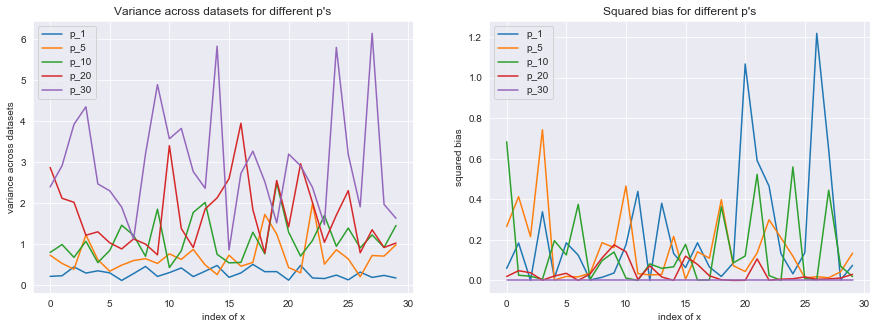

In [153]:
run = Project()
run.plot_bias_variance(p_list=p_list, p_true=p_true, N=N, iterations=iterations, distribution=distribution)

The above plots show that the higher the p (model complexity), the higher the variance (left plot) and the lower the bias (right plot).

Let's try to visualizes the Bias-Variance trade-off in a way that is more similar to Bishop's approach:

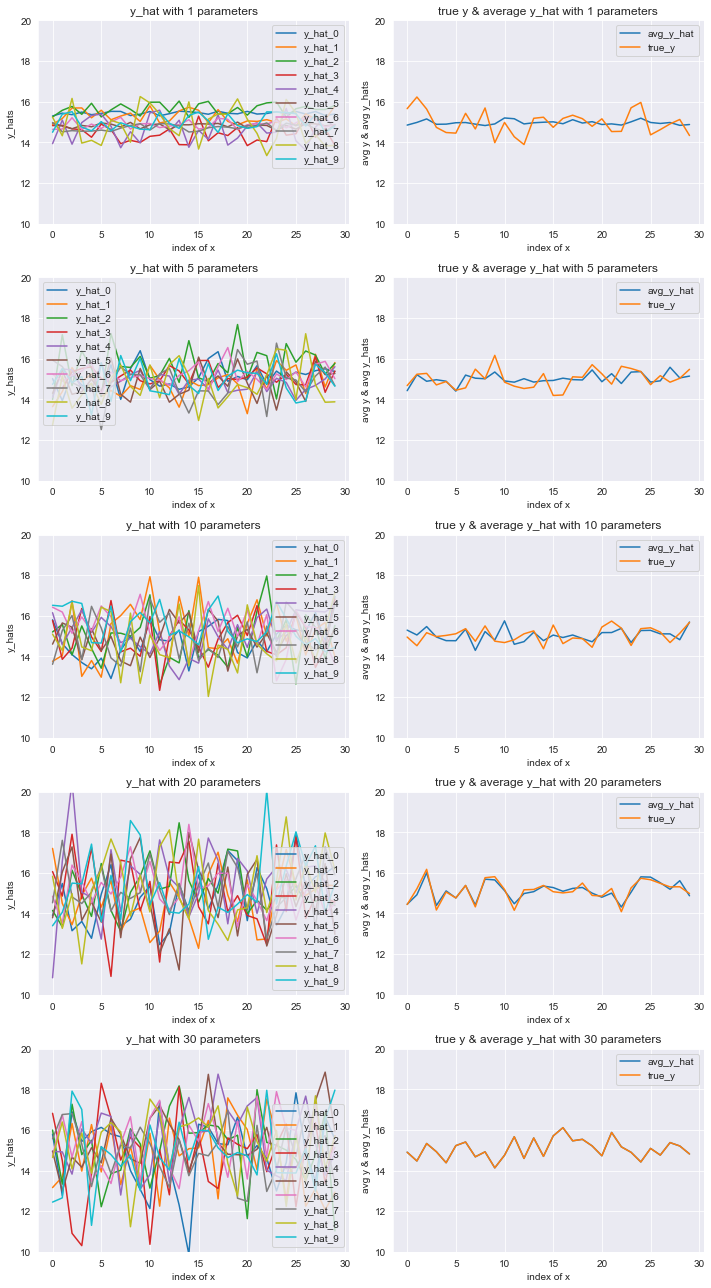

In [154]:
run.visualize_y(p_list=p_list, p_true=p_true, N=N, iterations=iterations, distribution=distribution)

On the left-hand-side we see how different iterations of creating predictions (from the same distribution) are more different from each other, the more parameters are used for prediction (that, even if with more predictions I get closer to the true model where p_true = 30)

On the right-hand-side we see that our average prediction (across datasets) is getting closer to the true y, the more parameters are chosen for estimating the model (bias shrinks with higher p).

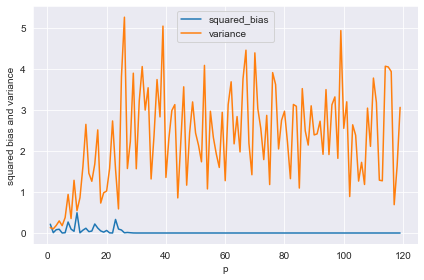

In [155]:
run.plot_bias_variance_over_p(p_true=p_true, p_max=120, N=N, iterations=iterations, distribution=distribution)

In the above plot, ultimately, I visualize the course of the squared bias and the variance over many (much bigger) values of p. The bias converges to 0 at p=30 (when p=p_true) and the variance increases up until p=30 and then stays steady.